In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_california_housing
#Test Push

print(f"TensorFlow Version: {tf.__version__}")

In [ ]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

train_adult = pd.read_csv("DataSets/census/adult.data", header=None, names=columns, sep=",", na_values=" ?", skipinitialspace=True)
test_adult = pd.read_csv("DataSets/census/adult.test", header=0, names=columns, sep=",", na_values=" ?", skipinitialspace=True, comment='|')
test_adult['income'] = test_adult['income'].str.replace('.', '', regex=False)

data_adult = pd.concat([train_adult, test_adult], ignore_index=True).dropna()


# Part 1: Feature-Level Interpretability (30 marks)  
You will use the California Housing and the Adult Census Income datasets in this part. You 
should train one feed-forward neural network for each dataset and apply the following 
interpretability techniques:

In [ ]:
# Adult Census Income Dataset pre-processing and neural network model

X_adult = data_adult.drop("income", axis=1)
y_adult = (data_adult["income"] == ">50K").astype(int)

# Identify categorical and numerical columns
cat_cols = X_adult.select_dtypes(include=['object']).columns
num_cols = X_adult.select_dtypes(exclude=['object']).columns

# Encode categorical & scale numeric
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

X_processed_adult = ct.fit_transform(X_adult)
X_train_adult, X_val_adult, y_train_adult, y_val_adult = train_test_split(X_processed_adult, y_adult, test_size=0.2, random_state=42)

input_dim = X_train_adult.shape[1]

# The feed-forward neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(
    X_train_adult, y_train_adult,
    validation_data=(X_val_adult, y_val_adult),
    epochs=10,
    batch_size=256,
    verbose=1
)

# Evaulate the model
loss, acc = model.evaluate(X_val_adult, y_val_adult, verbose=0)
print(f"Validation Accuracy: {acc:.4f}")

Epoch 1/10


c:\Users\jamie\OneDrive\Desktop\Interpretable AI Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7917 - loss: 0.4316 - val_accuracy: 0.8533 - val_loss: 0.3153
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8530 - loss: 0.3173 - val_accuracy: 0.8547 - val_loss: 0.3113
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8548 - loss: 0.3182 - val_accuracy: 0.8566 - val_loss: 0.3093
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8608 - loss: 0.3056 - val_accuracy: 0.8585 - val_loss: 0.3074
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8553 - loss: 0.3080 - val_accuracy: 0.8572 - val_loss: 0.3072
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8585 - loss: 0.3062 - val_accuracy: 0.8573 - val_loss: 0.3074
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.3038 - val_accuracy: 0.8590 - val_loss: 0.3057
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.3069 - val_accuracy: 0.8625 - val_

## 1. Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots (7 marks) 
### a. Use PDP to examine the average effect of at least two features. 

ValueError: 'estimator' must be a fitted regressor or classifier.

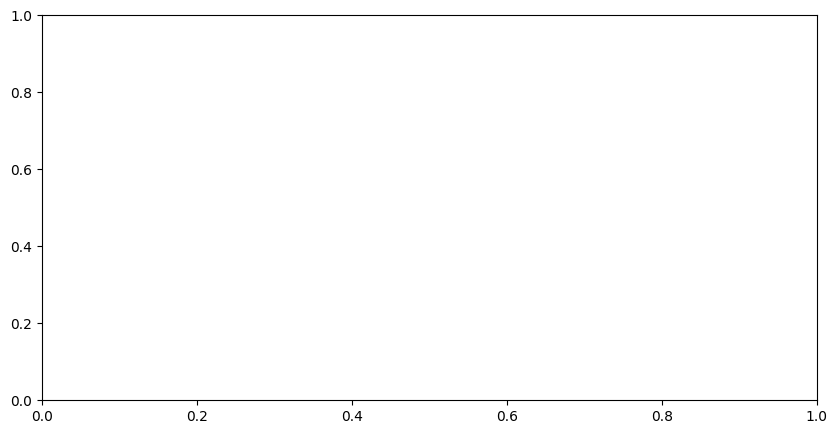

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

# --- Keras → sklearn wrapper ---
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    _estimator_type = "regressor"  # tell sklearn what this is
    
    def __init__(self, model):
        self.model = model

    def fit(self, X=None, y=None):
        # mark as fitted
        self.is_fitted_ = True
        return self

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')
        preds = self.model.predict(X, verbose=0)
        return preds.flatten()

# wrap model
keras_wrapper = KerasRegressorWrapper(model)
keras_wrapper.fit()  # mark as fitted

# --- PDP setup ---
feature_names = list(ct.get_feature_names_out())
edu_idx = feature_names.index('scale__education-num')
hours_idx = feature_names.index('scale__hours-per-week')

# --- plot PDPs ---
fig, ax = plt.subplots(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(
    keras_wrapper,
    X_val_adult,
    features=[(edu_idx, hours_idx)],  # tuple -> 2D PDP (interaction)
    feature_names=feature_names,
    grid_resolution=40,
    ax=ax
)
plt.suptitle("Partial Dependence: Education × Hours-per-week", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
#California Housing Data Set NN + PDP + ICE

### b. Use ICE plots to explore individual predictions for at least two features. 

### c. Explain what insights PDP and ICE give about the model’s behaviour.

## 2. Permutation Feature Importance (PFI) (7 marks) 
### a. Use PFI to identify the most important features in the model. 


### b. Explain what the term “important” means when using the PFI method. 

## 3. Accumulated Local Effects (ALE) (9 marks) 
### a. Implement ALE plots to investigate the local effects of feature changes. 

### b. Compare ALE with PDP and discuss any differences in the interpretability of these techniques.

## 4. Global Surrogates (7 marks) 
### a. Build an interpretable model to approximate the predictions of the feed-forward neural network model. 

### b. Analyse the surrogate model's effectiveness and discuss when such approximations are helpful.